In [1]:
import glob, os
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
# from sklearn.model_selection import train_test_split
import sklearn
print(sklearn.__version__)
from sklearn.cross_validation import train_test_split  
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import accuracy_score

0.19.1


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


# Exploring data sets

In [2]:
# read list of vehicles file
cars = []
for directory in glob.glob("data/vehicles/*"):
    cars.extend(glob.glob(directory+"/*"))
len(cars)

8792

In [3]:
notcars = []
for directory in glob.glob("data/non-vehicles/*"):
    notcars.extend(glob.glob(directory+"/*"))
len(notcars)

8968

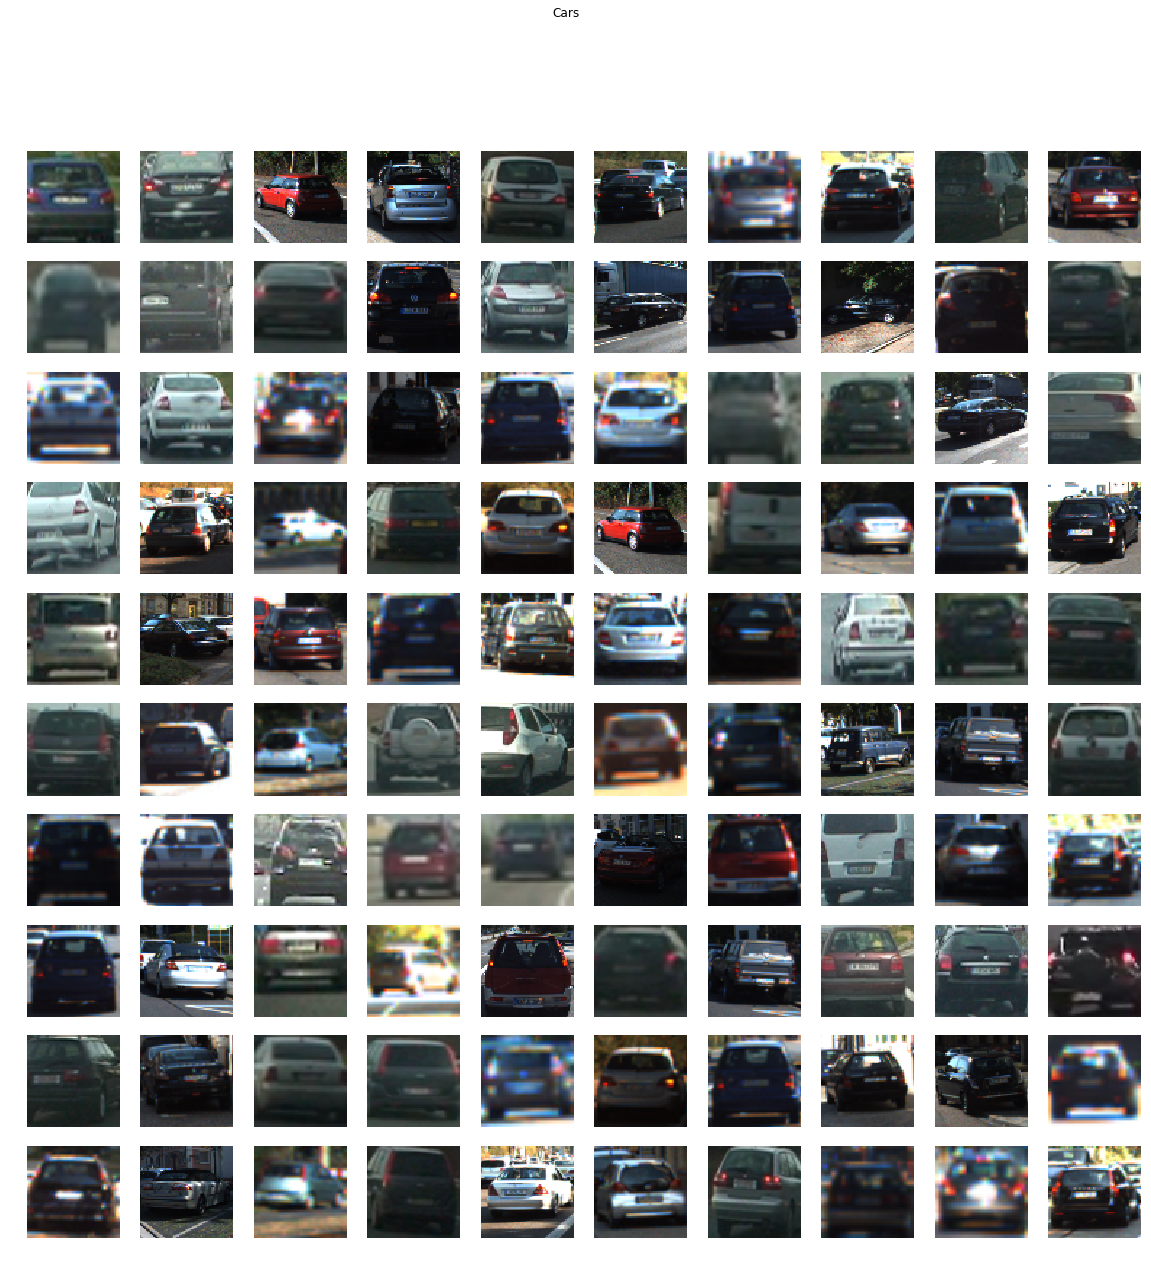

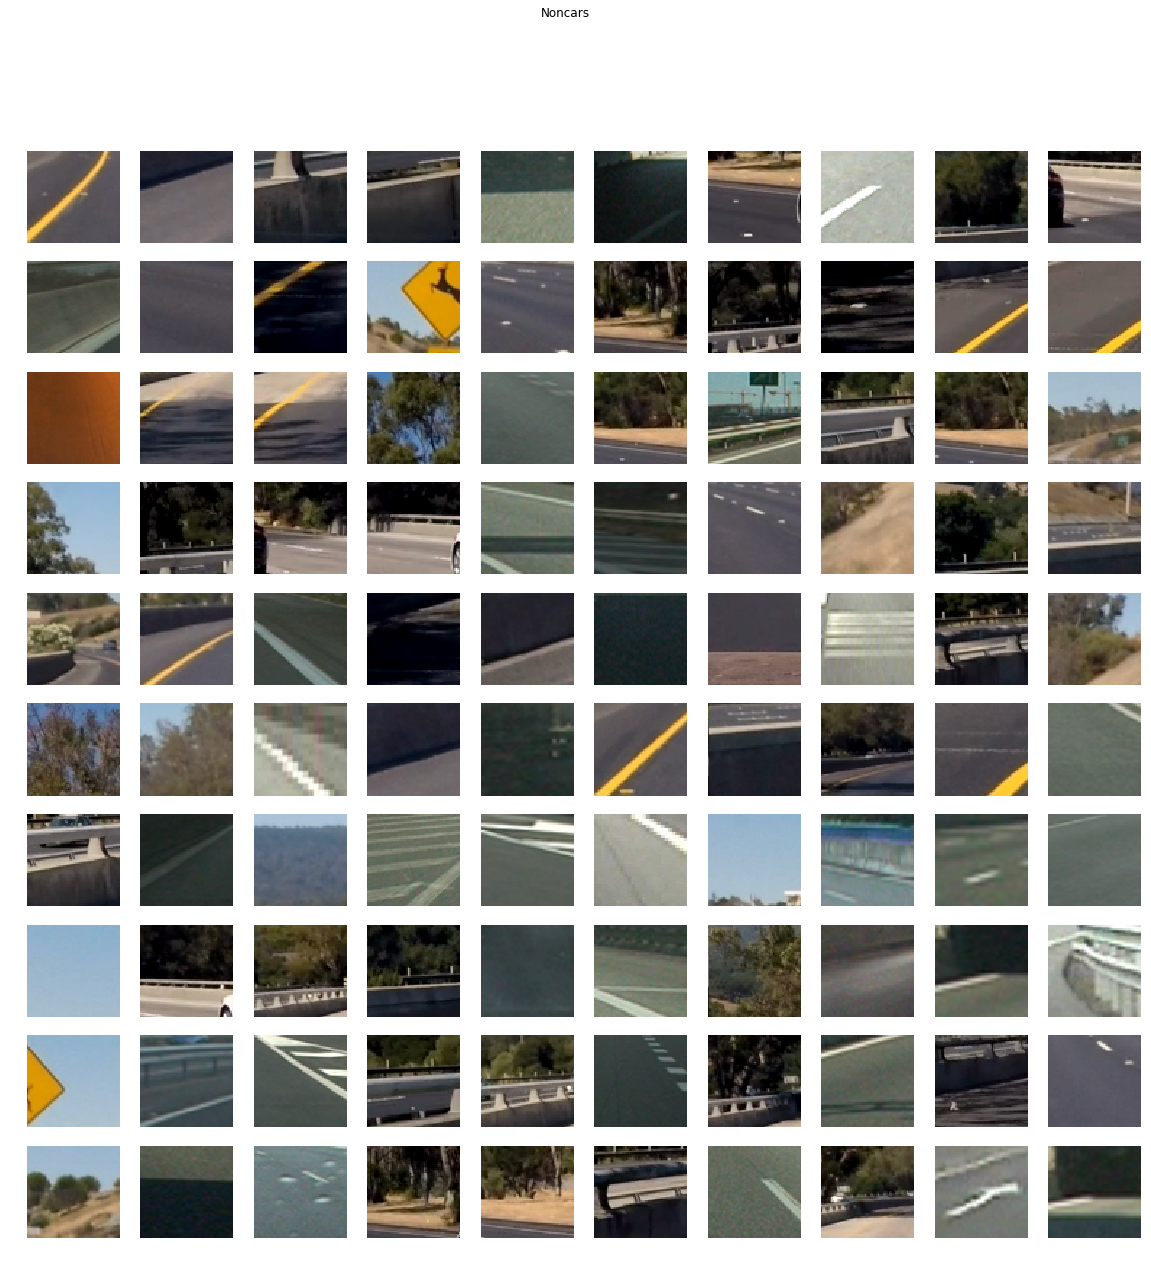

In [4]:
from random import shuffle

shuffle(cars)
shuffle(notcars)

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(cars[i]))
    plt.axis('off')
plt.suptitle('Cars')
plt.savefig('examples/cars_examples.png')

plt.figure(figsize=(20,20))    
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(mpimg.imread(notcars[i]))
    plt.axis('off')
plt.suptitle('Noncars')    
plt.savefig('examples/noncars_examples.png')
plt.show()


# Extracting various features

In [5]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


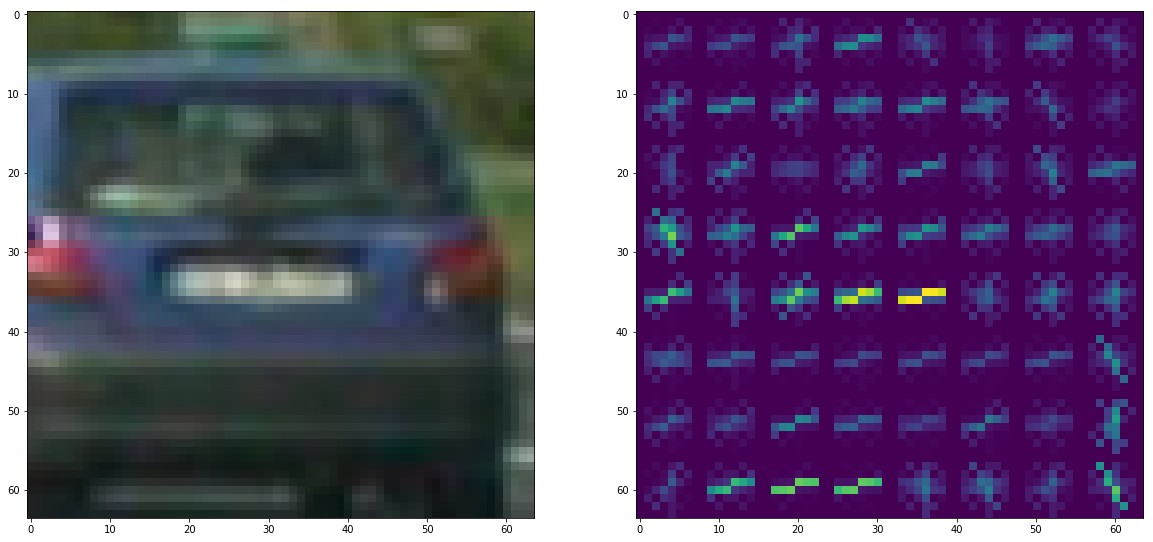

In [6]:
# test HOG visualization
img = mpimg.imread(cars[0])
orient = 9
pix_per_cell = 8
cell_per_block = 2
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=True)

plt.figure(figsize=(20,20));
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(hog_image)

In [7]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='HSV', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='HSV', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    

In [8]:
### TODO: Tweak these parameters and see how the results change.
colorspace = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size=(32, 32)
hist_bins=32
    
t=time.time()
car_features = extract_features(cars, color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
notcar_features = extract_features(notcars,  color_space=colorspace, spatial_size=spatial_size,
                        hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                        spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

104.8 Seconds to extract HOG features...


13840.255717363487
27145.722760847217


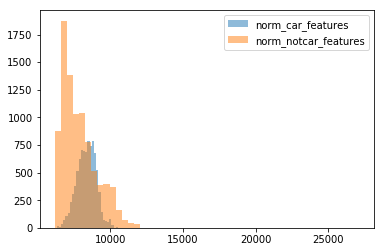

In [9]:
norm_car_features = [np.linalg.norm(x) for x in car_features ]
norm_notcar_features = [np.linalg.norm(x) for x in notcar_features ]

print(np.max(norm_car_features))
print(np.max(norm_notcar_features))

plt.hist(norm_car_features, 50,  alpha=0.5, label='norm_car_features')
plt.hist(norm_notcar_features, 50,  alpha=0.5, label='norm_notcar_features')
plt.legend(loc='upper right')
plt.show()

In [10]:
print(np.mean(norm_car_features))
print(np.mean(norm_notcar_features))

8350.698112070686
7856.78809466057


In [11]:
import pickle
with open('all_features.pickle', 'wb') as handle:
    pickle.dump({'car_features':car_features, 'notcar_features':notcar_features}, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Training classifiers

In [12]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler(copy=True, with_mean=True, with_std=True).fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


In [13]:
X_train.shape

(14208, 8460)

## Linear SVM

In [14]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

28.05 Seconds to train SVC...
Test Accuracy of SVC =  0.98
My SVC predicts:  [0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
For these 10 labels:  [0. 0. 1. 0. 0. 0. 1. 1. 0. 1.]
0.00191 Seconds to predict 10 labels with SVC


In [25]:
pickle.dump((model, X_scaler), open("SVM_allfeatures_HSV.pkl", "wb"))

## Xgboost

In [15]:
import xgboost as xgb
# read in data
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)


In [16]:
model = xgb.XGBClassifier(
 learning_rate =0.1,
 n_estimators=150,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.75,
 colsample_bytree=0.75,
 objective= 'binary:logistic',
 nthread=16,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.043004	validation_0-logloss:0.611781	validation_1-error:0.052365	validation_1-logloss:0.613381
[1]	validation_0-error:0.034417	validation_0-logloss:0.542855	validation_1-error:0.040822	validation_1-logloss:0.545828
[2]	validation_0-error:0.027027	validation_0-logloss:0.485742	validation_1-error:0.031813	validation_1-logloss:0.489622
[3]	validation_0-error:0.024986	validation_0-logloss:0.437069	validation_1-error:0.030687	validation_1-logloss:0.44193
[4]	validation_0-error:0.019989	validation_0-logloss:0.394244	validation_1-error:0.027309	validation_1-logloss:0.400337
[5]	validation_0-error:0.019848	validation_0-logloss:0.356953	validation_1-error:0.024775	validation_1-logloss:0.36351
[6]	validation_0-error:0.017525	validation_0-logloss:0.32447	validation_1-error:0.024775	validation_1-logloss:0.331791
[7]	validation_0-error:0.017103	validation_0-logloss:0.295036	validation_1-error:0.024212	validation_1-logloss:0.303266
[8]	validation_0-error:0.015414	validation_

[69]	validation_0-error:0	validation_0-logloss:0.00785	validation_1-error:0.008727	validation_1-logloss:0.0283
[70]	validation_0-error:0	validation_0-logloss:0.007555	validation_1-error:0.008446	validation_1-logloss:0.027908
[71]	validation_0-error:0	validation_0-logloss:0.007248	validation_1-error:0.008446	validation_1-logloss:0.027407
[72]	validation_0-error:0	validation_0-logloss:0.006972	validation_1-error:0.008727	validation_1-logloss:0.026999
[73]	validation_0-error:0	validation_0-logloss:0.00675	validation_1-error:0.008446	validation_1-logloss:0.02669
[74]	validation_0-error:0	validation_0-logloss:0.006533	validation_1-error:0.008446	validation_1-logloss:0.026469
[75]	validation_0-error:0	validation_0-logloss:0.006299	validation_1-error:0.008446	validation_1-logloss:0.026077
[76]	validation_0-error:0	validation_0-logloss:0.006075	validation_1-error:0.008446	validation_1-logloss:0.025782
[77]	validation_0-error:0	validation_0-logloss:0.005834	validation_1-error:0.008446	validatio

[141]	validation_0-error:0	validation_0-logloss:0.001312	validation_1-error:0.005912	validation_1-logloss:0.017537
[142]	validation_0-error:0	validation_0-logloss:0.001292	validation_1-error:0.005912	validation_1-logloss:0.017524
[143]	validation_0-error:0	validation_0-logloss:0.001274	validation_1-error:0.005912	validation_1-logloss:0.017521
[144]	validation_0-error:0	validation_0-logloss:0.001256	validation_1-error:0.005912	validation_1-logloss:0.017469
[145]	validation_0-error:0	validation_0-logloss:0.001239	validation_1-error:0.006194	validation_1-logloss:0.017436
[146]	validation_0-error:0	validation_0-logloss:0.001222	validation_1-error:0.005912	validation_1-logloss:0.017395
[147]	validation_0-error:0	validation_0-logloss:0.001208	validation_1-error:0.006194	validation_1-logloss:0.017329
[148]	validation_0-error:0	validation_0-logloss:0.001189	validation_1-error:0.005912	validation_1-logloss:0.017269
[149]	validation_0-error:0	validation_0-logloss:0.001175	validation_1-error:0.00

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.75, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=5, min_child_weight=1, missing=None, n_estimators=150,
       n_jobs=1, nthread=16, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.75)

In [17]:
# make predictions for test data
y_pred = model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 99.44%


/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [18]:
# save model to file
pickle.dump((model, X_scaler), open("xgboost_allfeatures_small_HSV.pkl", "wb"))

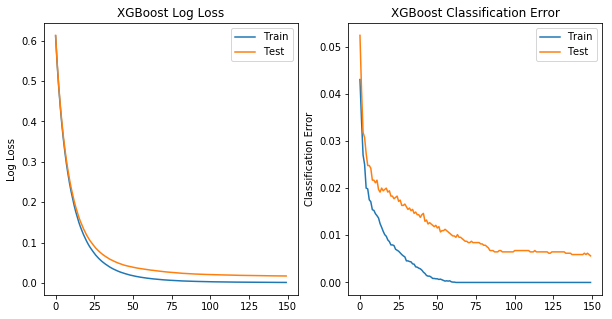

In [19]:
# retrieve performance metrics
def plot_model_learning_curve(model):
    results = model.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    plt.figure(figsize=(10,5))
    
    ax = plt.subplot(1,2,1)
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')

    # plot classification error
    ax = plt.subplot(1,2,2)
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')
    plt.show()
plot_model_learning_curve(model)

In [20]:
model2 = xgb.XGBClassifier(
 learning_rate = 0.05,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=1,
 gamma=0,
 subsample=0.5,
 colsample_bytree=0.5,
 objective= 'binary:logistic',
 nthread=16,
 scale_pos_weight=1)
eval_set = [(X_train, y_train), (X_test, y_test)]
model2.fit(X_train, y_train, eval_metric=["error", "logloss"], eval_set=eval_set, verbose=True, )


[0]	validation_0-error:0.062993	validation_0-logloss:0.654582	validation_1-error:0.068694	validation_1-logloss:0.654962
[1]	validation_0-error:0.055251	validation_0-logloss:0.618521	validation_1-error:0.056588	validation_1-logloss:0.618948
[2]	validation_0-error:0.049831	validation_0-logloss:0.586322	validation_1-error:0.055462	validation_1-logloss:0.586848
[3]	validation_0-error:0.046875	validation_0-logloss:0.555494	validation_1-error:0.050957	validation_1-logloss:0.556494
[4]	validation_0-error:0.038992	validation_0-logloss:0.527501	validation_1-error:0.041385	validation_1-logloss:0.528748
[5]	validation_0-error:0.036881	validation_0-logloss:0.50064	validation_1-error:0.038851	validation_1-logloss:0.502334
[6]	validation_0-error:0.034699	validation_0-logloss:0.47641	validation_1-error:0.038007	validation_1-logloss:0.478517
[7]	validation_0-error:0.033502	validation_0-logloss:0.453561	validation_1-error:0.035755	validation_1-logloss:0.455791
[8]	validation_0-error:0.032095	validation

[69]	validation_0-error:0.009783	validation_0-logloss:0.061252	validation_1-error:0.016329	validation_1-logloss:0.07313
[70]	validation_0-error:0.009713	validation_0-logloss:0.059844	validation_1-error:0.016329	validation_1-logloss:0.071726
[71]	validation_0-error:0.00922	validation_0-logloss:0.058485	validation_1-error:0.016047	validation_1-logloss:0.070469
[72]	validation_0-error:0.008939	validation_0-logloss:0.057331	validation_1-error:0.01661	validation_1-logloss:0.069364
[73]	validation_0-error:0.008939	validation_0-logloss:0.056105	validation_1-error:0.016329	validation_1-logloss:0.068226
[74]	validation_0-error:0.008727	validation_0-logloss:0.054918	validation_1-error:0.01661	validation_1-logloss:0.067254
[75]	validation_0-error:0.008727	validation_0-logloss:0.053701	validation_1-error:0.016329	validation_1-logloss:0.066223
[76]	validation_0-error:0.008516	validation_0-logloss:0.052661	validation_1-error:0.016047	validation_1-logloss:0.065183
[77]	validation_0-error:0.008305	val

[137]	validation_0-error:0.001619	validation_0-logloss:0.017568	validation_1-error:0.009854	validation_1-logloss:0.033187
[138]	validation_0-error:0.001548	validation_0-logloss:0.017281	validation_1-error:0.009854	validation_1-logloss:0.032934
[139]	validation_0-error:0.001548	validation_0-logloss:0.016995	validation_1-error:0.009854	validation_1-logloss:0.032596
[140]	validation_0-error:0.001478	validation_0-logloss:0.01669	validation_1-error:0.009854	validation_1-logloss:0.032384
[141]	validation_0-error:0.001337	validation_0-logloss:0.016433	validation_1-error:0.009854	validation_1-logloss:0.032254
[142]	validation_0-error:0.001337	validation_0-logloss:0.016191	validation_1-error:0.009854	validation_1-logloss:0.031979
[143]	validation_0-error:0.001337	validation_0-logloss:0.015935	validation_1-error:0.009572	validation_1-logloss:0.031746
[144]	validation_0-error:0.001197	validation_0-logloss:0.0157	validation_1-error:0.009572	validation_1-logloss:0.031542
[145]	validation_0-error:0.

[205]	validation_0-error:0.000282	validation_0-logloss:0.006959	validation_1-error:0.007038	validation_1-logloss:0.022596
[206]	validation_0-error:0.000282	validation_0-logloss:0.006879	validation_1-error:0.007038	validation_1-logloss:0.022492
[207]	validation_0-error:0.000282	validation_0-logloss:0.006807	validation_1-error:0.007038	validation_1-logloss:0.022365
[208]	validation_0-error:0.000282	validation_0-logloss:0.006711	validation_1-error:0.007038	validation_1-logloss:0.022269
[209]	validation_0-error:0.000282	validation_0-logloss:0.006636	validation_1-error:0.007038	validation_1-logloss:0.022252
[210]	validation_0-error:0.000282	validation_0-logloss:0.006544	validation_1-error:0.007038	validation_1-logloss:0.022153
[211]	validation_0-error:0.000282	validation_0-logloss:0.006484	validation_1-error:0.007038	validation_1-logloss:0.022088
[212]	validation_0-error:0.000211	validation_0-logloss:0.006417	validation_1-error:0.007038	validation_1-logloss:0.022021
[213]	validation_0-error

[273]	validation_0-error:7e-05	validation_0-logloss:0.003364	validation_1-error:0.005631	validation_1-logloss:0.018103
[274]	validation_0-error:7e-05	validation_0-logloss:0.003334	validation_1-error:0.005631	validation_1-logloss:0.018083
[275]	validation_0-error:7e-05	validation_0-logloss:0.003303	validation_1-error:0.005631	validation_1-logloss:0.017977
[276]	validation_0-error:7e-05	validation_0-logloss:0.003278	validation_1-error:0.005631	validation_1-logloss:0.017976
[277]	validation_0-error:7e-05	validation_0-logloss:0.003242	validation_1-error:0.005631	validation_1-logloss:0.0179
[278]	validation_0-error:7e-05	validation_0-logloss:0.003215	validation_1-error:0.005349	validation_1-logloss:0.017885
[279]	validation_0-error:7e-05	validation_0-logloss:0.003188	validation_1-error:0.005068	validation_1-logloss:0.017841
[280]	validation_0-error:7e-05	validation_0-logloss:0.003163	validation_1-error:0.005068	validation_1-logloss:0.017798
[281]	validation_0-error:7e-05	validation_0-loglos

[344]	validation_0-error:0	validation_0-logloss:0.001955	validation_1-error:0.005349	validation_1-logloss:0.016011
[345]	validation_0-error:0	validation_0-logloss:0.001942	validation_1-error:0.005349	validation_1-logloss:0.016004
[346]	validation_0-error:0	validation_0-logloss:0.001929	validation_1-error:0.005349	validation_1-logloss:0.015988
[347]	validation_0-error:0	validation_0-logloss:0.001919	validation_1-error:0.005349	validation_1-logloss:0.015975
[348]	validation_0-error:0	validation_0-logloss:0.001906	validation_1-error:0.005068	validation_1-logloss:0.015944
[349]	validation_0-error:0	validation_0-logloss:0.001893	validation_1-error:0.005349	validation_1-logloss:0.015967
[350]	validation_0-error:0	validation_0-logloss:0.001881	validation_1-error:0.005349	validation_1-logloss:0.015942
[351]	validation_0-error:0	validation_0-logloss:0.001868	validation_1-error:0.005349	validation_1-logloss:0.015917
[352]	validation_0-error:0	validation_0-logloss:0.001855	validation_1-error:0.00

[416]	validation_0-error:0	validation_0-logloss:0.001308	validation_1-error:0.005068	validation_1-logloss:0.014952
[417]	validation_0-error:0	validation_0-logloss:0.001301	validation_1-error:0.005068	validation_1-logloss:0.014911
[418]	validation_0-error:0	validation_0-logloss:0.001296	validation_1-error:0.005068	validation_1-logloss:0.014914
[419]	validation_0-error:0	validation_0-logloss:0.001291	validation_1-error:0.005068	validation_1-logloss:0.014906
[420]	validation_0-error:0	validation_0-logloss:0.001285	validation_1-error:0.005068	validation_1-logloss:0.014877
[421]	validation_0-error:0	validation_0-logloss:0.001279	validation_1-error:0.005068	validation_1-logloss:0.014905
[422]	validation_0-error:0	validation_0-logloss:0.001274	validation_1-error:0.005068	validation_1-logloss:0.014909
[423]	validation_0-error:0	validation_0-logloss:0.001268	validation_1-error:0.005068	validation_1-logloss:0.014937
[424]	validation_0-error:0	validation_0-logloss:0.001264	validation_1-error:0.00

[488]	validation_0-error:0	validation_0-logloss:0.000982	validation_1-error:0.005068	validation_1-logloss:0.014458
[489]	validation_0-error:0	validation_0-logloss:0.000979	validation_1-error:0.005068	validation_1-logloss:0.01445
[490]	validation_0-error:0	validation_0-logloss:0.000974	validation_1-error:0.005349	validation_1-logloss:0.014453
[491]	validation_0-error:0	validation_0-logloss:0.00097	validation_1-error:0.005068	validation_1-logloss:0.014459
[492]	validation_0-error:0	validation_0-logloss:0.000967	validation_1-error:0.005068	validation_1-logloss:0.014435
[493]	validation_0-error:0	validation_0-logloss:0.000963	validation_1-error:0.005068	validation_1-logloss:0.014438
[494]	validation_0-error:0	validation_0-logloss:0.000961	validation_1-error:0.005068	validation_1-logloss:0.014438
[495]	validation_0-error:0	validation_0-logloss:0.000958	validation_1-error:0.005068	validation_1-logloss:0.014442
[496]	validation_0-error:0	validation_0-logloss:0.000955	validation_1-error:0.0050

[560]	validation_0-error:0	validation_0-logloss:0.000794	validation_1-error:0.004786	validation_1-logloss:0.014028
[561]	validation_0-error:0	validation_0-logloss:0.000792	validation_1-error:0.004786	validation_1-logloss:0.014037
[562]	validation_0-error:0	validation_0-logloss:0.00079	validation_1-error:0.004786	validation_1-logloss:0.014034
[563]	validation_0-error:0	validation_0-logloss:0.000789	validation_1-error:0.004786	validation_1-logloss:0.014039
[564]	validation_0-error:0	validation_0-logloss:0.000787	validation_1-error:0.004786	validation_1-logloss:0.014036
[565]	validation_0-error:0	validation_0-logloss:0.000785	validation_1-error:0.004786	validation_1-logloss:0.014042
[566]	validation_0-error:0	validation_0-logloss:0.000783	validation_1-error:0.004786	validation_1-logloss:0.014024
[567]	validation_0-error:0	validation_0-logloss:0.000781	validation_1-error:0.004786	validation_1-logloss:0.014031
[568]	validation_0-error:0	validation_0-logloss:0.000779	validation_1-error:0.004

[632]	validation_0-error:0	validation_0-logloss:0.000672	validation_1-error:0.005068	validation_1-logloss:0.01381
[633]	validation_0-error:0	validation_0-logloss:0.00067	validation_1-error:0.005068	validation_1-logloss:0.013835
[634]	validation_0-error:0	validation_0-logloss:0.000669	validation_1-error:0.005068	validation_1-logloss:0.013853
[635]	validation_0-error:0	validation_0-logloss:0.000667	validation_1-error:0.005068	validation_1-logloss:0.013863
[636]	validation_0-error:0	validation_0-logloss:0.000666	validation_1-error:0.005068	validation_1-logloss:0.013834
[637]	validation_0-error:0	validation_0-logloss:0.000664	validation_1-error:0.005068	validation_1-logloss:0.013857
[638]	validation_0-error:0	validation_0-logloss:0.000663	validation_1-error:0.004786	validation_1-logloss:0.013856
[639]	validation_0-error:0	validation_0-logloss:0.000662	validation_1-error:0.004786	validation_1-logloss:0.013842
[640]	validation_0-error:0	validation_0-logloss:0.00066	validation_1-error:0.00478

[704]	validation_0-error:0	validation_0-logloss:0.000589	validation_1-error:0.004786	validation_1-logloss:0.013616
[705]	validation_0-error:0	validation_0-logloss:0.000589	validation_1-error:0.004786	validation_1-logloss:0.013623
[706]	validation_0-error:0	validation_0-logloss:0.000588	validation_1-error:0.004786	validation_1-logloss:0.01361
[707]	validation_0-error:0	validation_0-logloss:0.000587	validation_1-error:0.004786	validation_1-logloss:0.013603
[708]	validation_0-error:0	validation_0-logloss:0.000586	validation_1-error:0.004786	validation_1-logloss:0.013594
[709]	validation_0-error:0	validation_0-logloss:0.000585	validation_1-error:0.004505	validation_1-logloss:0.01359
[710]	validation_0-error:0	validation_0-logloss:0.000584	validation_1-error:0.004505	validation_1-logloss:0.013602
[711]	validation_0-error:0	validation_0-logloss:0.000584	validation_1-error:0.004505	validation_1-logloss:0.013614
[712]	validation_0-error:0	validation_0-logloss:0.000582	validation_1-error:0.0047

[776]	validation_0-error:0	validation_0-logloss:0.000532	validation_1-error:0.004505	validation_1-logloss:0.013411
[777]	validation_0-error:0	validation_0-logloss:0.000531	validation_1-error:0.004505	validation_1-logloss:0.013421
[778]	validation_0-error:0	validation_0-logloss:0.00053	validation_1-error:0.004505	validation_1-logloss:0.013431
[779]	validation_0-error:0	validation_0-logloss:0.000529	validation_1-error:0.004505	validation_1-logloss:0.013442
[780]	validation_0-error:0	validation_0-logloss:0.000529	validation_1-error:0.004505	validation_1-logloss:0.013448
[781]	validation_0-error:0	validation_0-logloss:0.000528	validation_1-error:0.004505	validation_1-logloss:0.013471
[782]	validation_0-error:0	validation_0-logloss:0.000527	validation_1-error:0.004505	validation_1-logloss:0.013478
[783]	validation_0-error:0	validation_0-logloss:0.000526	validation_1-error:0.004505	validation_1-logloss:0.013473
[784]	validation_0-error:0	validation_0-logloss:0.000526	validation_1-error:0.004

[848]	validation_0-error:0	validation_0-logloss:0.000484	validation_1-error:0.004505	validation_1-logloss:0.013205
[849]	validation_0-error:0	validation_0-logloss:0.000484	validation_1-error:0.004505	validation_1-logloss:0.013203
[850]	validation_0-error:0	validation_0-logloss:0.000484	validation_1-error:0.004505	validation_1-logloss:0.013201
[851]	validation_0-error:0	validation_0-logloss:0.000482	validation_1-error:0.004505	validation_1-logloss:0.013227
[852]	validation_0-error:0	validation_0-logloss:0.000482	validation_1-error:0.004505	validation_1-logloss:0.013226
[853]	validation_0-error:0	validation_0-logloss:0.000481	validation_1-error:0.004505	validation_1-logloss:0.013208
[854]	validation_0-error:0	validation_0-logloss:0.000481	validation_1-error:0.004505	validation_1-logloss:0.013208
[855]	validation_0-error:0	validation_0-logloss:0.000481	validation_1-error:0.004505	validation_1-logloss:0.013206
[856]	validation_0-error:0	validation_0-logloss:0.00048	validation_1-error:0.004

[920]	validation_0-error:0	validation_0-logloss:0.000451	validation_1-error:0.004223	validation_1-logloss:0.013045
[921]	validation_0-error:0	validation_0-logloss:0.000451	validation_1-error:0.004223	validation_1-logloss:0.013045
[922]	validation_0-error:0	validation_0-logloss:0.000451	validation_1-error:0.004223	validation_1-logloss:0.01305
[923]	validation_0-error:0	validation_0-logloss:0.00045	validation_1-error:0.004223	validation_1-logloss:0.013063
[924]	validation_0-error:0	validation_0-logloss:0.00045	validation_1-error:0.004505	validation_1-logloss:0.013065
[925]	validation_0-error:0	validation_0-logloss:0.000449	validation_1-error:0.004505	validation_1-logloss:0.013066
[926]	validation_0-error:0	validation_0-logloss:0.000449	validation_1-error:0.004223	validation_1-logloss:0.013055
[927]	validation_0-error:0	validation_0-logloss:0.000449	validation_1-error:0.004223	validation_1-logloss:0.013053
[928]	validation_0-error:0	validation_0-logloss:0.000448	validation_1-error:0.00450

[992]	validation_0-error:0	validation_0-logloss:0.000426	validation_1-error:0.004505	validation_1-logloss:0.012955
[993]	validation_0-error:0	validation_0-logloss:0.000425	validation_1-error:0.004505	validation_1-logloss:0.012945
[994]	validation_0-error:0	validation_0-logloss:0.000425	validation_1-error:0.004505	validation_1-logloss:0.012945
[995]	validation_0-error:0	validation_0-logloss:0.000425	validation_1-error:0.004505	validation_1-logloss:0.012958
[996]	validation_0-error:0	validation_0-logloss:0.000424	validation_1-error:0.004505	validation_1-logloss:0.012957
[997]	validation_0-error:0	validation_0-logloss:0.000424	validation_1-error:0.004505	validation_1-logloss:0.012952
[998]	validation_0-error:0	validation_0-logloss:0.000424	validation_1-error:0.004505	validation_1-logloss:0.012958
[999]	validation_0-error:0	validation_0-logloss:0.000424	validation_1-error:0.004505	validation_1-logloss:0.012953


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.5, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=16, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.55%


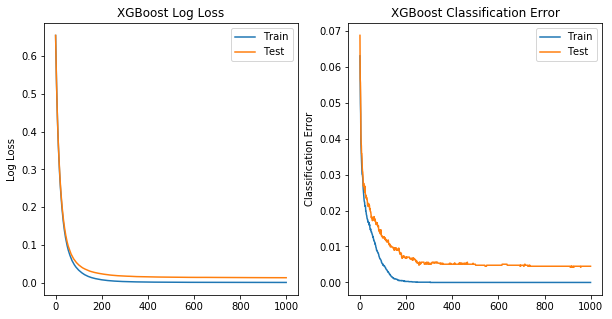

In [21]:
# make predictions for test data
y_pred = model2.predict(X_test)
#predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)

In [22]:
# save model to file
pickle.dump((model2, X_scaler), open("xgboost_allfeatures_large_HSV.pkl", "wb"))

In [23]:
# load model from file
loaded_model, X_scaler = pickle.load(open("xgboost_allfeatures_large_HSV.pkl", "rb"))

/home/xnguyen/.local/lib/python3.5/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Accuracy: 99.55%


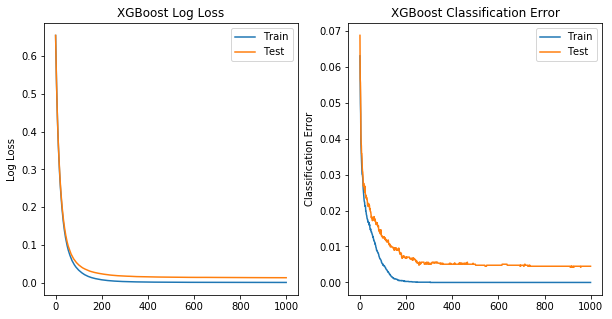

In [24]:
# make predictions for test data
y_pred = loaded_model.predict(X_test)
# evaluate predictions
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
plot_model_learning_curve(model2)